# Compare particle diffusion models
In this notebook we compare the different models for mass transport within the electrode particles. For a full list of all the particle models, see the [documentation](https://docs.pybamm.org/en/latest/source/api/models/submodels/particle/index.html).

With the "Fickian diffusion" option a diffusion equation is solved within the particle domain, with the boundary flux prescribed at the surface related to the local current density. Alternatively, one can assume a particular (polynomial) concentration profile within the particle (at present, this can be uniform, quadratic, or quartic). The "uniform profile" model assumes that the concentration inside the particle is uniform in space (and therefore equal to the surface concentration through the entire particle - in effect ignoring transport resistance within the particle), and solves an ODE for the average particle concentration. The "quadratic profile" model additionally solves an algebraic equation for the surface concentration, taking into account the effect of diffusion within the particle. Finally, the "quartic profile" model also solves for the average concentration gradient (the integral of $\partial c/ \partial r$) in the particle, giving a higher-order approximation to the concentration profile within the particle.

As the exchange current density is a function of surface concentration, we can see the effect the choice of particle model has on the voltage profile arising from different overpotentials.

First we import the packages we're going to use

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


We then create a list of models with the different particle diffusion submodels using the options functionality

In [2]:
particle_options = ["Fickian diffusion", "uniform profile", "quadratic profile", "quartic profile"]
models = [pybamm.lithium_ion.DFN(options={'particle': opt}, name=opt) for opt in particle_options]

Next we set up simulations for each model with the current set as an input function. We will change this later to observe the effect on the different models.

In [3]:
simulations = []
for model in models:
    param = model.default_parameter_values
    param["Current function [A]"] = "[input]"
    simulations.append(pybamm.Simulation(model, parameter_values=param))

In [4]:
t_eval = np.linspace(0, 3600, 72)

First we run the simulations for each model with a current of 0.68A - this corresponds to a C-rate of about 1 with the standard cell size configured in the default parameters.

In [5]:
solutions_1C = []
for sim in simulations:
    sim.solve(t_eval, inputs={"Current function [A]": 0.68})
    solutions_1C.append(sim.solution)
    print("Particle model: {}".format(sim.model.name))
    print("Solve time: {}s".format(sim.solution.solve_time))

Particle model: Fickian diffusion
Solve time: 344.798 mss
Particle model: uniform profile
Solve time: 207.218 mss
Particle model: quadratic profile
Solve time: 220.810 mss
Particle model: quartic profile
Solve time: 284.064 mss


By not solving the diffusion problem in the particles explicitly, and instead assuming a polynomial profile, we can speed up the simulation.

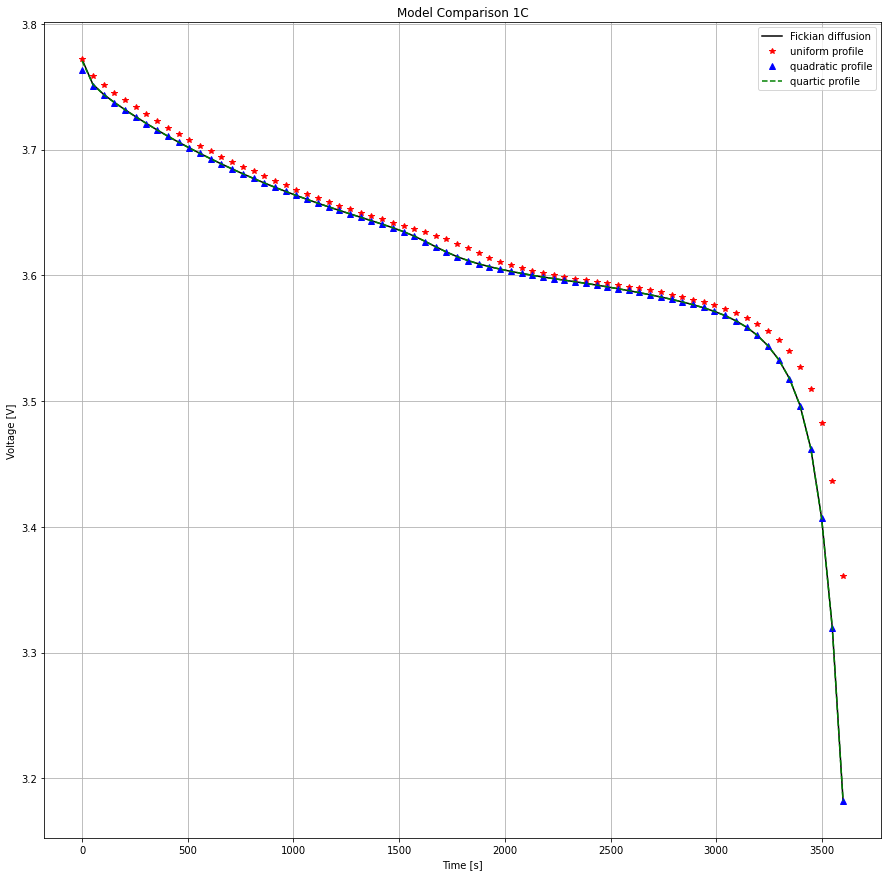

In [6]:
plt.figure(figsize=(15, 15))
style = ['k', 'r*', 'b^', 'g--']
for i in range(len(models)):
    plt.plot(solutions_1C[i]['Time [s]'].entries,
             solutions_1C[i]['Voltage [V]'].entries, style[i], label=particle_options[i])
plt.legend()
plt.title('Model Comparison 1C')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

We can see that the Fickian, quadratic and quartic profiles agree very well and that the uniform profile over-predicts the cell voltage and capacity by ignoring this transport resistance. The only significant difference between the Fickian and quadratic models is on the first datapoint when transient effects after the initial state may differ. Observe what happens next when we increase the current.

In [7]:
t_eval = np.linspace(0, 1800, 72)
solutions_2C = []
for sim in simulations:
    sim.solve(t_eval, inputs={"Current function [A]": 2*0.68})
    solutions_2C.append(sim.solution)

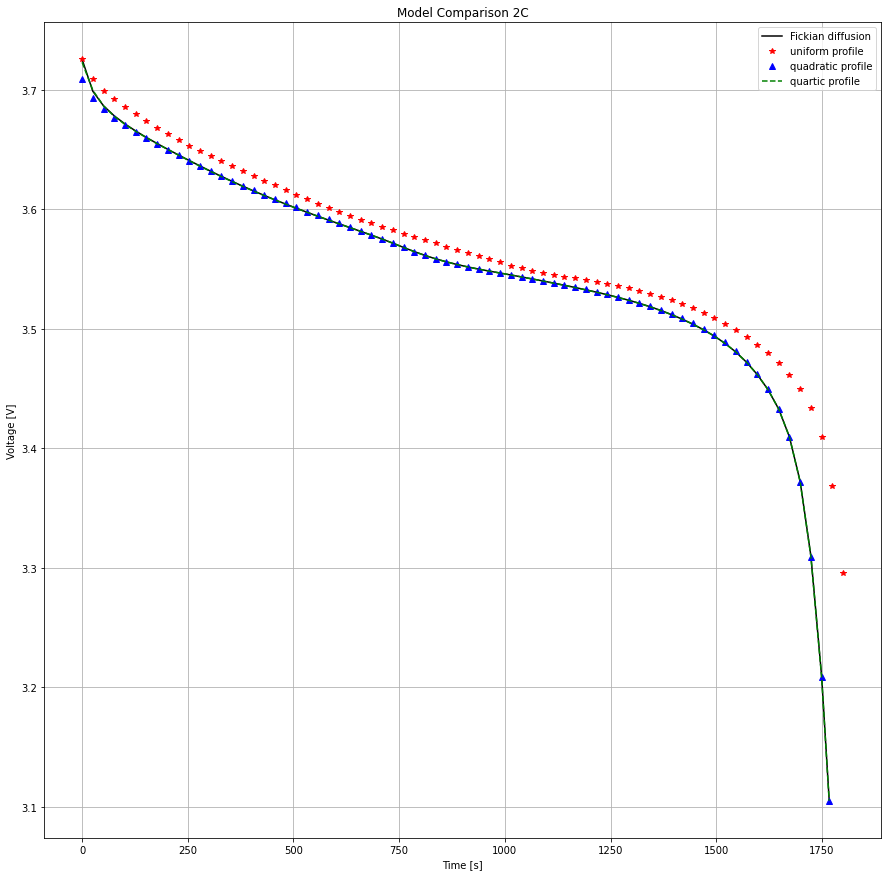

In [8]:
plt.figure(figsize=(15, 15))
for i in range(len(models)):
    plt.plot(solutions_2C[i]['Time [s]'].entries,
             solutions_2C[i]['Voltage [V]'].entries, style[i], label=particle_options[i])
plt.legend()
plt.title('Model Comparison 2C')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

The quadratic model is still much better at approximating Fickian diffusion and the relative error in the uniform model has increased. However, the initial error in the quadratic model has grown slightly. Increasing current even more will highlight the problem further. The quartic model is still providing an excellent match to the Fickian diffusion profile.

In [9]:
t_eval = np.linspace(0, 360, 72)
solutions_6C = []
for sim in simulations:
    sim.solve(t_eval, inputs={"Current function [A]": 6*0.68})
    solutions_6C.append(sim.solution)

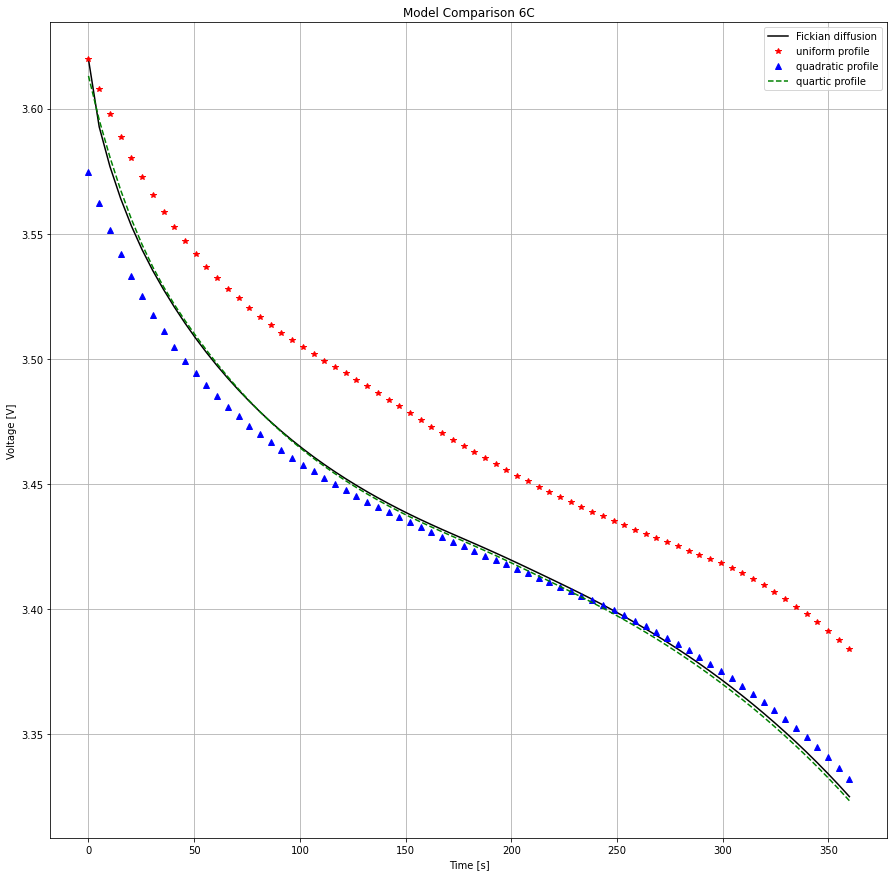

In [10]:
plt.figure(figsize=(15, 15))
for i in range(len(models)):
    plt.plot(solutions_6C[i]['Time [s]'].entries,
             solutions_6C[i]['Voltage [V]'].entries, style[i], label=particle_options[i])
plt.legend()
plt.title('Model Comparison 6C')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

Now the quadratic profile assumption begins to breakdown and that initial error propagates much further into the discharge. Happily the quartic model is higher-order and the match to the Fickian profile is still very good.

Finally we can take a look at some of the internal states using PyBaMM's `dynamic_plot`

In [11]:
pybamm.dynamic_plot(solutions_6C);

interactive(children=(FloatSlider(value=0.0, description='t', max=360.0, step=3.6), Output()), _dom_classes=('…

## References

The relevant papers for this notebook are:

In [12]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/